In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

%pdb

Automatic pdb calling has been turned ON


In [2]:
import classification as cl


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
gadi = False

In [4]:
if gadi:
    base_dir = '/g/data/wr45/'
else:
    base_dir = 'https://dapds00.nci.org.au/thredds/dodsC/wr45/'
base_dir += 'ops_aps3/access-g/1/'

In [15]:
datetimes_2020 = np.arange(
    np.datetime64('2020-10-01'), 
    np.datetime64('2021-05-01'),
    np.timedelta64(1, 'D'))
datetimes_2021 = np.arange(
    np.datetime64('2021-10-01'), 
    np.datetime64('2022-05-01'),
    np.timedelta64(1, 'D'))

datetimes = np.concatenate([datetimes_2020, datetimes_2021])

In [18]:
datetimes_bad = [
    np.datetime64('2021-03-24'), np.datetime64('2021-03-25'), 
    np.datetime64('2021-01-11'), np.datetime64('2021-01-12'),
    np.datetime64('2022-02-03'), np.datetime64('2022-02-04'),
    np.datetime64('2022-02-16'), np.datetime64('2022-02-17')]

In [19]:
datetimes = sorted(list(
    set(datetimes) - set(datetimes_bad)))

In [20]:
dt = datetimes[0]
date = str(dt)[0:10].replace('-', '')
hour = '0000'
u_an = xr.open_dataset(
    base_dir + date + '/' + hour + '/an/sfc/uwnd10m.nc')
v_an = xr.open_dataset(
    base_dir + date + '/' + hour + '/an/sfc/vwnd10m.nc')

lon_min = 129
lon_max = 135.01
lat_min = -10
lat_max = -16

u_an = u_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
v_an = v_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

u_an_lon_stable = u_an.lon
u_an_lat_stable = u_an.lat
v_an_lon_stable = v_an.lon
v_an_lat_stable = v_an.lat

In [21]:
u_fc_all = [None for i in range(5)]
v_fc_all = [None for i in range(5)]
u_an_all = [None for i in range(5)]
v_an_all = [None for i in range(5)]

hours = [0, 6, 12, 18, 24]

missing_forecasts = []
missing_analyses = []

for dt in datetimes:
    
    fc_data_datetime = dt - np.timedelta64(1, 'D')
    fc_date_str = str(fc_data_datetime)[0:10].replace('-', '')

    try:
        u_fc = xr.open_dataset(
            base_dir + fc_date_str + '/' + '0600' + '/fc/sfc/uwnd10m.nc')
        v_fc = xr.open_dataset(
            base_dir + fc_date_str + '/' + '0600' + '/fc/sfc/vwnd10m.nc')
    except FileNotFoundError:
        print('Forecast data missing at {}'.format(dt))
        missing_forecasts.append(
            base_dir + fc_date_str + '/' + '0600' + '/fc/sfc/uwnd10m.nc')
        continue
        
    u_fc = u_fc.sel(
        lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    v_fc = v_fc.sel(
        lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    for i in range(len(hours)):

        print('Getting {} 00:00 + {} data.'.format(dt, hours[i]))
        
        an_datetime = dt + np.timedelta64(hours[i], 'h')

        date = str(an_datetime)[0:10].replace('-', '')
        hour = str(an_datetime)[11:14] + '00'
        
        try:
            u_an = xr.open_dataset(
                base_dir + date + '/' + hour + '/an/sfc/uwnd10m.nc')
            v_an = xr.open_dataset(
                base_dir + date + '/' + hour + '/an/sfc/vwnd10m.nc')

            an_datetime = np.datetime64(
                '{}-{}-{}T{}:00:00'.format(
                    date[0:4], date[4:6], date[6:], hour[:2]))
        except OSError:
            print('Analysis data missing at {} hour {}'.format(date, hour))
            missing_analyses.append(
                base_dir + date + '/' + hour + '/an/sfc/uwnd10m.nc')
            continue

        lon_min = 129
        lon_max = 135.01
        lat_min = -10
        lat_max = -16

        u_fc_i = u_fc.sel(time=an_datetime)
        v_fc_i = v_fc.sel(time=an_datetime)
        u_an = u_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
        v_an = v_an.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
        
        u_fc_i['time'] = u_fc_i['time'] - np.timedelta64(hours[i], 'h')
        v_fc_i['time'] = v_fc_i['time'] - np.timedelta64(hours[i], 'h')
        u_an_i['time'] = u_an_i['time'] - np.timedelta64(hours[i], 'h')
        v_an_i['time'] = v_an_i['time'] - np.timedelta64(hours[i], 'h')

        u_an['lon'] = u_an_lon_stable
        u_an['lat'] = u_an_lat_stable
        v_an['lon'] = v_an_lon_stable
        v_an['lat'] = v_an_lat_stable

        u_fc_i['lon'] = u_an_lon_stable
        u_fc_i['lat'] = u_an_lat_stable
        v_fc_i['lon'] = v_an_lon_stable
        v_fc_i['lat'] = v_an_lat_stable

        if u_fc_all[i] is None:
            u_fc_all[i] = copy.deepcopy(u_fc_i)
            v_fc_all[i] = copy.deepcopy(v_fc_i)
            u_an_all[i] = copy.deepcopy(u_an)
            v_an_all[i] = copy.deepcopy(v_an)
        else:
            u_fc_all[i] = xr.concat([u_fc_all[i], u_fc_i], dim='time')
            v_fc_all[i] = xr.concat([v_fc_all[i], v_fc_i], dim='time')
            u_an_all[i] = xr.concat([u_an_all[i], u_an], dim='time')
            v_an_all[i] = xr.concat([v_an_all[i], v_an], dim='time')

Getting 2020-10-01 00:00 + 0 data.
Getting 2020-10-01 00:00 + 6 data.
Getting 2020-10-01 00:00 + 12 data.
Getting 2020-10-01 00:00 + 18 data.
Getting 2020-10-01 00:00 + 24 data.
Getting 2020-10-02 00:00 + 0 data.
Getting 2020-10-02 00:00 + 6 data.
Getting 2020-10-02 00:00 + 12 data.
Getting 2020-10-02 00:00 + 18 data.
Getting 2020-10-02 00:00 + 24 data.
Getting 2020-10-03 00:00 + 0 data.
Getting 2020-10-03 00:00 + 6 data.
Getting 2020-10-03 00:00 + 12 data.
Getting 2020-10-03 00:00 + 18 data.
Getting 2020-10-03 00:00 + 24 data.
Getting 2020-10-04 00:00 + 0 data.
Getting 2020-10-04 00:00 + 6 data.
Getting 2020-10-04 00:00 + 12 data.
Getting 2020-10-04 00:00 + 18 data.
Getting 2020-10-04 00:00 + 24 data.
Getting 2020-10-05 00:00 + 0 data.
Getting 2020-10-05 00:00 + 6 data.
Getting 2020-10-05 00:00 + 12 data.
Getting 2020-10-05 00:00 + 18 data.
Getting 2020-10-05 00:00 + 24 data.
Getting 2020-10-06 00:00 + 0 data.
Getting 2020-10-06 00:00 + 6 data.
Getting 2020-10-06 00:00 + 12 data.
Gett

Getting 2020-11-16 00:00 + 12 data.
Getting 2020-11-16 00:00 + 18 data.
Getting 2020-11-16 00:00 + 24 data.
Getting 2020-11-17 00:00 + 0 data.
Getting 2020-11-17 00:00 + 6 data.
Getting 2020-11-17 00:00 + 12 data.
Getting 2020-11-17 00:00 + 18 data.
Getting 2020-11-17 00:00 + 24 data.
Getting 2020-11-18 00:00 + 0 data.
Getting 2020-11-18 00:00 + 6 data.
Getting 2020-11-18 00:00 + 12 data.
Getting 2020-11-18 00:00 + 18 data.
Getting 2020-11-18 00:00 + 24 data.
Getting 2020-11-19 00:00 + 0 data.
Getting 2020-11-19 00:00 + 6 data.
Getting 2020-11-19 00:00 + 12 data.
Getting 2020-11-19 00:00 + 18 data.
Getting 2020-11-19 00:00 + 24 data.
Getting 2020-11-20 00:00 + 0 data.
Getting 2020-11-20 00:00 + 6 data.
Getting 2020-11-20 00:00 + 12 data.
Getting 2020-11-20 00:00 + 18 data.
Getting 2020-11-20 00:00 + 24 data.
Getting 2020-11-21 00:00 + 0 data.
Getting 2020-11-21 00:00 + 6 data.
Getting 2020-11-21 00:00 + 12 data.
Getting 2020-11-21 00:00 + 18 data.
Getting 2020-11-21 00:00 + 24 data.
Ge

Getting 2021-01-01 00:00 + 18 data.
Getting 2021-01-01 00:00 + 24 data.
Getting 2021-01-02 00:00 + 0 data.
Getting 2021-01-02 00:00 + 6 data.
Getting 2021-01-02 00:00 + 12 data.
Getting 2021-01-02 00:00 + 18 data.
Getting 2021-01-02 00:00 + 24 data.
Getting 2021-01-03 00:00 + 0 data.
Getting 2021-01-03 00:00 + 6 data.
Getting 2021-01-03 00:00 + 12 data.
Getting 2021-01-03 00:00 + 18 data.
Getting 2021-01-03 00:00 + 24 data.
Getting 2021-01-04 00:00 + 0 data.
Getting 2021-01-04 00:00 + 6 data.
Getting 2021-01-04 00:00 + 12 data.
Getting 2021-01-04 00:00 + 18 data.
Getting 2021-01-04 00:00 + 24 data.
Getting 2021-01-05 00:00 + 0 data.
Getting 2021-01-05 00:00 + 6 data.
Getting 2021-01-05 00:00 + 12 data.
Getting 2021-01-05 00:00 + 18 data.
Getting 2021-01-05 00:00 + 24 data.
Getting 2021-01-06 00:00 + 0 data.
Getting 2021-01-06 00:00 + 6 data.
Getting 2021-01-06 00:00 + 12 data.
Getting 2021-01-06 00:00 + 18 data.
Getting 2021-01-06 00:00 + 24 data.
Getting 2021-01-07 00:00 + 0 data.
Get

Getting 2021-02-18 00:00 + 24 data.
Getting 2021-02-19 00:00 + 0 data.
Getting 2021-02-19 00:00 + 6 data.
Getting 2021-02-19 00:00 + 12 data.
Getting 2021-02-19 00:00 + 18 data.
Getting 2021-02-19 00:00 + 24 data.
Getting 2021-02-20 00:00 + 0 data.
Getting 2021-02-20 00:00 + 6 data.
Getting 2021-02-20 00:00 + 12 data.
Getting 2021-02-20 00:00 + 18 data.
Getting 2021-02-20 00:00 + 24 data.
Getting 2021-02-21 00:00 + 0 data.
Getting 2021-02-21 00:00 + 6 data.
Getting 2021-02-21 00:00 + 12 data.
Getting 2021-02-21 00:00 + 18 data.
Getting 2021-02-21 00:00 + 24 data.
Getting 2021-02-22 00:00 + 0 data.
Getting 2021-02-22 00:00 + 6 data.
Getting 2021-02-22 00:00 + 12 data.
Getting 2021-02-22 00:00 + 18 data.
Getting 2021-02-22 00:00 + 24 data.
Getting 2021-02-23 00:00 + 0 data.
Getting 2021-02-23 00:00 + 6 data.
Getting 2021-02-23 00:00 + 12 data.
Getting 2021-02-23 00:00 + 18 data.
Getting 2021-02-23 00:00 + 24 data.
Getting 2021-02-24 00:00 + 0 data.
Getting 2021-02-24 00:00 + 6 data.
Gett

Getting 2021-04-08 00:00 + 0 data.
Getting 2021-04-08 00:00 + 6 data.
Getting 2021-04-08 00:00 + 12 data.
Getting 2021-04-08 00:00 + 18 data.
Getting 2021-04-08 00:00 + 24 data.
Getting 2021-04-09 00:00 + 0 data.
Getting 2021-04-09 00:00 + 6 data.
Getting 2021-04-09 00:00 + 12 data.
Getting 2021-04-09 00:00 + 18 data.
Getting 2021-04-09 00:00 + 24 data.
Getting 2021-04-10 00:00 + 0 data.
Getting 2021-04-10 00:00 + 6 data.
Getting 2021-04-10 00:00 + 12 data.
Getting 2021-04-10 00:00 + 18 data.
Getting 2021-04-10 00:00 + 24 data.
Getting 2021-04-11 00:00 + 0 data.
Getting 2021-04-11 00:00 + 6 data.
Getting 2021-04-11 00:00 + 12 data.
Getting 2021-04-11 00:00 + 18 data.
Getting 2021-04-11 00:00 + 24 data.
Getting 2021-04-12 00:00 + 0 data.
Getting 2021-04-12 00:00 + 6 data.
Getting 2021-04-12 00:00 + 12 data.
Getting 2021-04-12 00:00 + 18 data.
Getting 2021-04-12 00:00 + 24 data.
Getting 2021-04-13 00:00 + 0 data.
Getting 2021-04-13 00:00 + 6 data.
Getting 2021-04-13 00:00 + 12 data.
Gett

Getting 2021-10-24 00:00 + 12 data.
Getting 2021-10-24 00:00 + 18 data.
Getting 2021-10-24 00:00 + 24 data.
Getting 2021-10-25 00:00 + 0 data.
Getting 2021-10-25 00:00 + 6 data.
Getting 2021-10-25 00:00 + 12 data.
Getting 2021-10-25 00:00 + 18 data.
Getting 2021-10-25 00:00 + 24 data.
Getting 2021-10-26 00:00 + 0 data.
Getting 2021-10-26 00:00 + 6 data.
Getting 2021-10-26 00:00 + 12 data.
Getting 2021-10-26 00:00 + 18 data.
Getting 2021-10-26 00:00 + 24 data.
Getting 2021-10-27 00:00 + 0 data.
Getting 2021-10-27 00:00 + 6 data.
Getting 2021-10-27 00:00 + 12 data.
Getting 2021-10-27 00:00 + 18 data.
Getting 2021-10-27 00:00 + 24 data.
Getting 2021-10-28 00:00 + 0 data.
Getting 2021-10-28 00:00 + 6 data.
Getting 2021-10-28 00:00 + 12 data.
Getting 2021-10-28 00:00 + 18 data.
Getting 2021-10-28 00:00 + 24 data.
Getting 2021-10-29 00:00 + 0 data.
Getting 2021-10-29 00:00 + 6 data.
Getting 2021-10-29 00:00 + 12 data.
Getting 2021-10-29 00:00 + 18 data.
Getting 2021-10-29 00:00 + 24 data.
Ge

Getting 2021-12-09 00:00 + 18 data.
Getting 2021-12-09 00:00 + 24 data.
Getting 2021-12-10 00:00 + 0 data.
Getting 2021-12-10 00:00 + 6 data.
Getting 2021-12-10 00:00 + 12 data.
Getting 2021-12-10 00:00 + 18 data.
Getting 2021-12-10 00:00 + 24 data.
Getting 2021-12-11 00:00 + 0 data.
Getting 2021-12-11 00:00 + 6 data.
Getting 2021-12-11 00:00 + 12 data.
Getting 2021-12-11 00:00 + 18 data.
Getting 2021-12-11 00:00 + 24 data.
Getting 2021-12-12 00:00 + 0 data.
Getting 2021-12-12 00:00 + 6 data.
Getting 2021-12-12 00:00 + 12 data.
Getting 2021-12-12 00:00 + 18 data.
Getting 2021-12-12 00:00 + 24 data.
Getting 2021-12-13 00:00 + 0 data.
Getting 2021-12-13 00:00 + 6 data.
Getting 2021-12-13 00:00 + 12 data.
Getting 2021-12-13 00:00 + 18 data.
Getting 2021-12-13 00:00 + 24 data.
Getting 2021-12-14 00:00 + 0 data.
Getting 2021-12-14 00:00 + 6 data.
Getting 2021-12-14 00:00 + 12 data.
Getting 2021-12-14 00:00 + 18 data.
Getting 2021-12-14 00:00 + 24 data.
Getting 2021-12-15 00:00 + 0 data.
Get

Getting 2022-01-24 00:00 + 24 data.
Getting 2022-01-25 00:00 + 0 data.
Getting 2022-01-25 00:00 + 6 data.
Getting 2022-01-25 00:00 + 12 data.
Getting 2022-01-25 00:00 + 18 data.
Getting 2022-01-25 00:00 + 24 data.
Getting 2022-01-26 00:00 + 0 data.
Getting 2022-01-26 00:00 + 6 data.
Getting 2022-01-26 00:00 + 12 data.
Getting 2022-01-26 00:00 + 18 data.
Getting 2022-01-26 00:00 + 24 data.
Getting 2022-01-27 00:00 + 0 data.
Getting 2022-01-27 00:00 + 6 data.
Getting 2022-01-27 00:00 + 12 data.
Getting 2022-01-27 00:00 + 18 data.
Getting 2022-01-27 00:00 + 24 data.
Getting 2022-01-28 00:00 + 0 data.
Getting 2022-01-28 00:00 + 6 data.
Getting 2022-01-28 00:00 + 12 data.
Getting 2022-01-28 00:00 + 18 data.
Getting 2022-01-28 00:00 + 24 data.
Getting 2022-01-29 00:00 + 0 data.
Getting 2022-01-29 00:00 + 6 data.
Getting 2022-01-29 00:00 + 12 data.
Getting 2022-01-29 00:00 + 18 data.
Getting 2022-01-29 00:00 + 24 data.
Getting 2022-01-30 00:00 + 0 data.
Getting 2022-01-30 00:00 + 6 data.
Gett

Getting 2022-03-16 00:00 + 0 data.
Getting 2022-03-16 00:00 + 6 data.
Getting 2022-03-16 00:00 + 12 data.
Getting 2022-03-16 00:00 + 18 data.
Getting 2022-03-16 00:00 + 24 data.
Getting 2022-03-17 00:00 + 0 data.
Getting 2022-03-17 00:00 + 6 data.
Getting 2022-03-17 00:00 + 12 data.
Getting 2022-03-17 00:00 + 18 data.
Getting 2022-03-17 00:00 + 24 data.
Getting 2022-03-18 00:00 + 0 data.
Getting 2022-03-18 00:00 + 6 data.
Getting 2022-03-18 00:00 + 12 data.
Getting 2022-03-18 00:00 + 18 data.
Getting 2022-03-18 00:00 + 24 data.
Getting 2022-03-19 00:00 + 0 data.
Getting 2022-03-19 00:00 + 6 data.
Getting 2022-03-19 00:00 + 12 data.
Getting 2022-03-19 00:00 + 18 data.
Getting 2022-03-19 00:00 + 24 data.
Getting 2022-03-20 00:00 + 0 data.
Getting 2022-03-20 00:00 + 6 data.
Getting 2022-03-20 00:00 + 12 data.
Getting 2022-03-20 00:00 + 18 data.
Getting 2022-03-20 00:00 + 24 data.
Getting 2022-03-21 00:00 + 0 data.
Getting 2022-03-21 00:00 + 6 data.
Getting 2022-03-21 00:00 + 12 data.
Gett

In [22]:
hours = [0, 6, 12, 18, 24]

u_fc_cc = xr.concat(u_fc_all, dim=hours)
u_fc_cc = u_fc_cc.rename({'concat_dim': 'hour'})
u_fc_cc.to_netcdf('ACCESS_G_u_fc_all.nc')

v_fc_cc = xr.concat(v_fc_all, dim=hours)
v_fc_cc = v_fc_cc.rename({'concat_dim': 'hour'})
v_fc_cc.to_netcdf('ACCESS_G_v_fc_all.nc')

u_an_cc = xr.concat(u_an_all, dim=hours)
u_an_cc = u_an_cc.rename({'concat_dim': 'hour'})
u_an_cc.to_netcdf('ACCESS_G_u_an_all.nc')

v_an_cc = xr.concat(v_an_all, dim=hours)
v_an_cc.rename({'concat_dim': 'hour'})
v_an_cc.to_netcdf('ACCESS_G_v_an_all.nc')

/jobfs/57519064.gadi-pbs/ipykernel_655789/582212725.py:5: SerializationWarning: saving variable forc_minutes with floating point data as an integer dtype without any _FillValue to use for NaNs
  u_fc_cc.to_netcdf('ACCESS_G_u_fc_all.nc')
/jobfs/57519064.gadi-pbs/ipykernel_655789/582212725.py:9: SerializationWarning: saving variable forc_minutes with floating point data as an integer dtype without any _FillValue to use for NaNs
  v_fc_cc.to_netcdf('ACCESS_G_v_fc_all.nc')
/jobfs/57519064.gadi-pbs/ipykernel_655789/582212725.py:13: SerializationWarning: saving variable forc_minutes with floating point data as an integer dtype without any _FillValue to use for NaNs
  u_an_cc.to_netcdf('ACCESS_G_u_an_all.nc')
/jobfs/57519064.gadi-pbs/ipykernel_655789/582212725.py:17: SerializationWarning: saving variable forc_minutes with floating point data as an integer dtype without any _FillValue to use for NaNs
  v_an_cc.to_netcdf('ACCESS_G_v_an_all.nc')


In [27]:
u_fc_all = xr.open_dataset('ACCESS_G_u_fc_all.nc')
v_fc_all = xr.open_dataset('ACCESS_G_v_fc_all.nc')
u_an_all = xr.open_dataset('ACCESS_G_u_an_all.nc')
v_an_all = xr.open_dataset('ACCESS_G_v_an_all.nc')

In [28]:
# Destagger
u_fc_all = u_fc_all.rolling(lon=2).mean()
u_fc_all = u_fc_all.sel(lon = slice(u_fc_all.lon[1], u_fc_all.lon[-1]))
u_fc_all['lon'] = v_fc_all.lon

u_fc_all = u_fc_all.rolling(lat=2).mean()
u_fc_all = u_fc_all.sel(lat = slice(u_fc_all.lat[1], u_fc_all.lat[-1]))
u_fc_all['lat'] = v_fc_all.lat

u_an_all = u_an_all.rolling(lon=2).mean()
u_an_all = u_an_all.sel(lon = slice(u_an_all.lon[1], u_an_all.lon[-1]))
u_an_all['lon'] = v_an_all.lon

u_an_all = u_an_all.rolling(lat=2).mean()
u_an_all = u_an_all.sel(lat = slice(u_an_all.lat[1], u_an_all.lat[-1]))
u_an_all['lat'] = v_an_all.lat

In [29]:
u_err = u_fc_all['uwnd10m'] - u_an_all['uwnd10m']
v_err = v_fc_all['vwnd10m'] - v_an_all['vwnd10m']

In [30]:
abs_vec_diff = np.sqrt(u_err**2+v_err**2)

In [31]:
abs_vec_diff_h = abs_vec_diff.mean(dim='hour')

In [51]:
u_an_all.time

<xarray.DataArray 'time' (time: 1670)>
array(['2020-10-01T00:00:00.000000000', '2020-10-01T06:00:00.000000000',
       '2020-10-01T12:00:00.000000000', ..., '2022-04-30T12:00:00.000000000',
       '2022-04-30T18:00:00.000000000', '2022-05-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-10-01 2020-10-01T06:00:00 ... 2022-05-01
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

In [ ]:
ERA5_u = xr.open_dataarray('/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/ERA5_u.nc')
ERA5_v = xr.open_dataarray('/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/ERA5_v.nc')

In [19]:
common_times = sorted(set(
    ERA5_u['time'].values).intersection(u_fc_all['time'].values).intersection(u_an_all['time'].values))

In [20]:
ERA5_u = ERA5_u.sel(time=common_times)
ERA5_v = ERA5_v.sel(time=common_times)
ERA5_u = ERA5_u.rename({'longitude': 'lon', 'latitude': 'lat'})
ERA5_v = ERA5_v.rename({'longitude': 'lon', 'latitude': 'lat'})

In [22]:
u_fc_all = u_fc_all.sel(time=common_times)
v_fc_all = v_fc_all.sel(time=common_times)
u_an_all = u_an_all.sel(time=common_times)
v_an_all = v_an_all.sel(time=common_times)

In [23]:
ERA5_u = ERA5_u.interp(lon=u_fc_all.lon, lat=u_fc_all.lat)
ERA5_v = ERA5_v.interp(lon=u_fc_all.lon, lat=u_fc_all.lat)

In [24]:
u_err_ERA5 = u_fc_all['uwnd10m'] - ERA5_u
v_err_ERA5 = v_fc_all['vwnd10m'] - ERA5_v

In [25]:
abs_vec_diff_ERA5 = np.sqrt(u_err_ERA5**2+v_err_ERA5**2)

In [26]:
abs_vec_diff_ERA5_h = abs_vec_diff_ERA5.groupby(abs_vec_diff['time'].dt.hour).mean()

ValueError: the group variable's length does not match the length of this variable along its dimension

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/xarray/core/groupby.py(327)__init__()
    325         expected_size = obj.sizes[group_dim]
    326         if group.size != expected_size:
--> 327             raise ValueError(
    328                 "the group variable's length does not "
    329                 "match the length of this variable along its "

ipdb> q


In [35]:
era5_dir = '/g/data/rt52/era5/single-levels/reanalysis/'
wind_dir = 'v'

years_months = [
    [2020, 10], [2020, 11], [2020, 12], [2021, 1], [2021, 2], [2021, 3], [2021, 4],
    [2021, 10], [2021, 11], [2021, 12], [2022, 1], [2022, 2], [2022, 3], [2022, 4]
]

end_day_dict = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 10: 31, 11: 30, 12: 31}

ERA5_all = [None for i in range(5)]
hours = [0, 6, 12, 18, 24]
for year_month in years_months:
      
    fn1 = era5_dir + '10{}/{:04}/10{}_era5_oper_sfc_{:04}{:02}01-{:04}{:02}{:02}.nc'.format(
        wind_dir, year_month[0], wind_dir, year_month[0], year_month[1], 
        year_month[0], year_month[1], end_day_dict[year_month[1]])
    start_date = np.datetime64('{:04}-{:02}-01'.format(year_month[0], year_month[1]))
    
    if year_month[1] == 12:
        fn2 = era5_dir + '10{}/{:04}/10{}_era5_oper_sfc_{:04}{:02}01-{:04}{:02}31.nc'.format(
            wind_dir, year_month[0]+1, wind_dir, 
            year_month[0]+1, 1, year_month[0]+1, 1)
        end_date = np.datetime64('{:04}-{:02}-01'.format(year_month[0]+1, 1))
    else:
        fn2 = era5_dir + '10{}/{:04}/10{}_era5_oper_sfc_{:04}{:02}01-{:04}{:02}{:02}.nc'.format(
            wind_dir, year_month[0], wind_dir, year_month[0], 
            year_month[1]+1, year_month[0], year_month[1]+1,
            end_day_dict[year_month[1]+1])
        end_date = np.datetime64('{:04}-{:02}-01'.format(year_month[0], year_month[1]+1))
    
    print('Getting {} {}'.format(wind_dir, fn1))
    
    ERA5_base = xr.open_mfdataset([fn1, fn2])

    lon_min = 128
    lon_max = 137
    lat_min = -9
    lat_max = -17
    
    ERA5_base = ERA5_base.sel(
        longitude=slice(lon_min, lon_max), 
        latitude=slice(lat_min, lat_max))
    ERA5_base.load()

    times = np.arange(start_date, end_date, np.timedelta64(1, 'D'))
    
    for i in range(len(hours)):

        times_i = times + np.timedelta64(hours[i], 'h')
        ERA5 = ERA5_base.sel(time=times_i)
        ERA5['time'] = ERA5['time'] - np.timedelta64(hours[i], 'h')

        if ERA5_all[i] is None:
            ERA5_all[i] = copy.deepcopy(ERA5)
        else:
            ERA5_all[i] = xr.concat([ERA5_all[i], ERA5], dim='time')

ERA5_all = xr.concat(ERA5_all, dim=hours)
ERA5_all = ERA5_all.rename({'concat_dim': 'hour'})
ERA5_all.to_netcdf('ERA5_{}.nc'.format(wind_dir))

Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2020/10v_era5_oper_sfc_20201001-20201031.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2020/10v_era5_oper_sfc_20201101-20201130.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2020/10v_era5_oper_sfc_20201201-20201231.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20210101-20210131.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20210201-20210228.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20210301-20210331.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20210401-20210430.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20211001-20211031.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20211101-20211130.nc
Getting v /g/data/rt52/era5/single-levels/reanalysis/10v/2021/10v_era5_oper_sfc_20211201-20

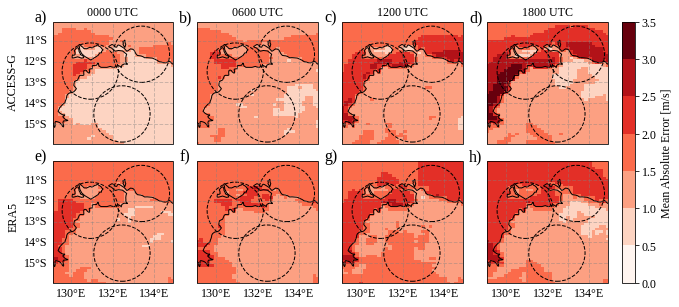

In [236]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12, 5))

axes = []

title = ['0000 UTC', '0600 UTC', '1200 UTC', '1800 UTC'] * 2

for i in range(8):

    ax = fig.add_subplot(2, 4, i+1, projection=ccrs.PlateCarree())
    axes.append(ax)

    lons = abs_vec_diff_h.lon
    lats = abs_vec_diff_h.lat

    ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], crs=ccrs.PlateCarree())

    grid = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=1, color='gray', alpha=0.4, linestyle='--')

    grid.xlocator = mticker.FixedLocator(np.arange(129, 136, 1))
    grid.ylocator = mticker.FixedLocator(np.arange(-9, -17, -1))

    grid.right_labels = False
    grid.top_labels = False
    grid.left_labels = False
    grid.bottom_labels = False
    
    if i == 0:
        grid.left_labels = True      
    elif i==4:
        grid.left_labels = True
        grid.bottom_labels = True
    elif i>4:
        grid.bottom_labels = True


    LONS, LATS = np.meshgrid(lons, lats)

    levels = np.arange(0, 3.75, .5)

    cmap = plt.get_cmap('Reds')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    if i <= 3:
        data = abs_vec_diff_h
    else:
        data = abs_vec_diff_ERA5_h

    pcmesh = ax.pcolormesh(
        LONS, LATS, data.isel(hour=i%4), 
        cmap=cmap, norm=norm)

    # fig.colorbar(pcmesh, ax=ax)

    ax.coastlines(resolution='50m', zorder=1)
      
    B_radius = plt.Circle(
        (130.925, -12.457), 150/111, edgecolor='k', linestyle='--', 
        facecolor='none', linewidth=1, label='Scanning Boundary')
    A_radius = plt.Circle(
        (133.38, -11.6485), 150/111, edgecolor='k', linestyle='--', 
        facecolor='none', linewidth=1)
    T_radius = plt.Circle(
        (132.446, -14.513), 150/111, edgecolor='k', linestyle='--', 
        facecolor='none', linewidth=1)
    ax.add_patch(B_radius)
    ax.add_patch(A_radius)
    ax.add_patch(T_radius)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.2)
    if i<4:
        ax.set_title(title[i], fontsize=12)
    if i==0:
        ax.text(-.375, .3, 'ACCESS-G', rotation=90, transform=ax.transAxes, fontsize=12)
    if i==4:
        ax.text(-.375, .45, 'ERA5', rotation=90, transform=ax.transAxes, fontsize=12)
    
cbar = fig.colorbar(pcmesh, ax=axes, shrink=.96, pad=.02)
cbar.set_label('Mean Absolute Error [m/s]')
cl.make_subplot_labels(axes)

plt.savefig(
    'ambient_error.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')